In [14]:
import re
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import multinomial

%matplotlib inline

In [5]:
train_grocery_df, test_grocery_df, X_train, X_test, train_household_ids, test_household_ids = pickle.load(open('/home/adrien/Projects/MNMM/data.p', 'rb'))

In [51]:
def multinomial_prob(counts, beta):
    n = counts.sum(axis=-1)
    m = multinomial(n, beta)
    return m.pmf(counts)

def compute_log_likelihood(X_test, alpha, beta):
    mn_probs = np.zeros(X_test.shape[0])
    for k in range(beta.shape[0]):
        mn_probs_k = alpha[k] * multinomial_prob(X_test, beta[k])
        mn_probs += mn_probs_k
    mn_probs[mn_probs == 0] = np.finfo(float).eps
    return np.log(mn_probs).sum()

def compute_bic(X_test, alpha, beta, log_likelihood=None):
    if log_likelihood is None:
        log_likelihood = compute_log_likelihood(X_test, alpha, beta)
    N = X_test.shape[0]
    if len(alpha.shape) == 2:
        unique_alpha = np.unique(alpha, axis=0)
        nb_params_penalty = (unique_alpha.shape[0] * unique_alpha.shape[1] - 1) + (beta.shape[0] * (beta.shape[0] - 1))
    else:
        nb_params_penalty = (alpha.shape[0] - 1) + (beta.shape[0] * (beta.shape[0] - 1))
    return -log_likelihood + (0.5 * np.log(N) * nb_params_penalty)

def get_fit_metrics(pickle_dir, load_pickle):
    bics = {}
    likelihoods = {}
    for filename in tqdm(os.listdir(pickle_dir)):
        match = re.match('best_params_([0-9]+).p', filename)    
        if match is None:
            continue
        filepath = os.path.join(pickle_dir, filename)
        test_log_likelihood, best_alpha, best_beta, best_gamma = load_pickle(filepath)
        k = int(match.groups()[0])
        likelihoods[k] = test_log_likelihood
        bics[k] = compute_bic(X_test, best_alpha, best_beta, test_log_likelihood)
    return likelihoods, bics

def plot_values_by_k(values_by_k, title, label, ax, plot_min=None):
    sorted_kvp = list(sorted(values_by_k.items(), key=lambda kvp: kvp[0]))
    keys = [l[0] for l in sorted_kvp]
    values = [l[1] for l in sorted_kvp]
    sns.scatterplot(x=keys, y=values, ax=ax, label=label)
    ax.set_title(title)
    ax.set_xlabel('Number of clusters')
    if plot_min is not None:
        min_key = plot_min
        min_idx = [i for i, k in enumerate(keys) if k == plot_min][0]
        ax.scatter([min_key], [values[min_idx]], color='red')

def plot_fit_metrics(pickle_dir, load_pickle):
    likelihoods, bics, icl_bics = get_fit_metrics(pickle_dir, load_pickle)
    
    fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
    axes = axes.ravel()
    plot_values_by_k(likelihoods, 'Likelihood', axes[0])
    plot_values_by_k(bics, 'BIC', axes[1], plot_min=True)

def compare_fit_metrics(pickle_dir1, pickle_dir2, load_pickle):
    likelihoods1, bics1 = get_fit_metrics(pickle_dir1, load_pickle)
    likelihoods2, bics2 = get_fit_metrics(pickle_dir2, load_pickle)
    
    del bics1[1]
    del bics2[1]
    
    fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
    axes = axes.ravel()
    plot_values_by_k(likelihoods1, 'Likelihood', 'Global', axes[0])
    plot_values_by_k(likelihoods2, 'Likelihood', 'Individual', axes[0])
    axes[0].legend()
    plot_values_by_k(bics1, 'BIC', 'Global', axes[1], plot_min=30)
    plot_values_by_k(bics2, 'BIC', 'Individual', axes[1], plot_min=2)
    axes[1].legend()

def load_pickle(filepath):
    best_train_loss, test_log_likelihood, test_bic, best_alpha, best_beta, best_gamma = args = pickle.load(open(filepath, 'rb'))
    return test_log_likelihood, best_alpha, best_beta, best_gamma

100%|██████████| 21/21 [00:35<00:00,  1.71s/it]


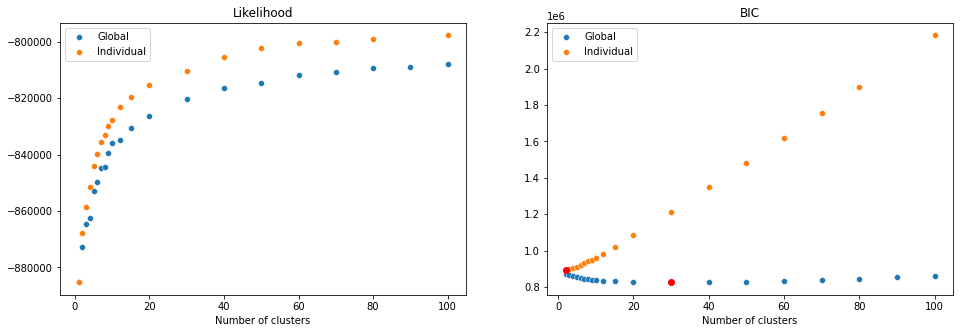

In [52]:
global_results_dir = '/home/adrien/Projects/MNMM/run_with_gamma'
individual_results_dir = '/home/adrien/Projects/MNMM/run_with_individuals'
compare_fit_metrics(global_results_dir, individual_results_dir, load_pickle)